<a href="https://colab.research.google.com/github/poorvjeet/LogisticRegressionmodelcodeveda/blob/main/regressionmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup complete.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset not found in Google Drive. Please upload manually.


Saving 1) iris.csv to 1) iris (2).csv
Saving 3) Sentiment dataset.csv to 3) Sentiment dataset (1).csv
Saving 4) house Prediction Data Set.csv to 4) house Prediction Data Set (1).csv
Data loaded. Shape: (150, 5)
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
Using text column: 'text', label column: 'label'
Label distribution:
label_grouped
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64
Vectorization complete. Train shape: (120, 4)
MultinomialNB Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      setosa       0.33      1.00      0.50        10
  versicolor       0.00      0.00      0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

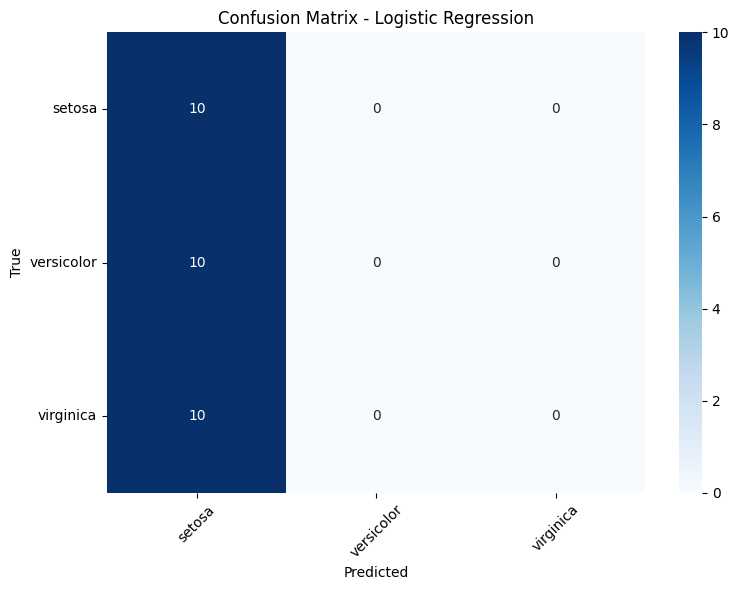

GPU not available. Skipping DistilBERT fine-tuning.
Mounted at /content/drive
Models saved to Google Drive.
Process completed successfully!


In [ ]:
# Task 3 — NLP (Sentiment Classification) — Full Colab Notebook

## 1. Setup & Installation

# Install all required packages
!pip install pandas numpy matplotlib scikit-learn seaborn transformers datasets --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import os

print("Setup complete.")

## 2. Load Dataset

from google.colab import files

# Try to mount Google Drive first
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # Check for dataset in common locations
    possible_paths = [
        '/content/drive/MyDrive/3) Sentiment dataset.csv',
        '/content/drive/MyDrive/Sentiment dataset.csv',
        '/content/drive/MyDrive/Colab Notebooks/Sentiment dataset.csv'
    ]

    for path in possible_paths:
        if os.path.exists(path):
            df = pd.read_csv(path)
            print(f"Data loaded from {path}")
            break
    else:
        print("Dataset not found in Google Drive. Please upload manually.")
        uploaded = files.upload()
        filename = next(iter(uploaded.keys()))
        df = pd.read_csv(filename)

except Exception as e:
    print("Google Drive mount failed:", e)
    print("Please upload your dataset file.")
    uploaded = files.upload()
    filename = next(iter(uploaded.keys()))
    df = pd.read_csv(filename)

print("Data loaded. Shape:", df.shape)
print(df.head())

## 3. Preprocessing — detect columns, clean labels, group to Top-5 + 'other'

# For the Iris dataset, let's create a text column by combining all features
# and use the species as the label
if 'species' in df.columns:
    # Create a text column by combining all features
    df['text'] = df.apply(lambda row: f"sepal_length {row['sepal_length']} sepal_width {row['sepal_width']} petal_length {row['petal_length']} petal_width {row['petal_width']}", axis=1)
    df['label'] = df['species']

    text_col = 'text'
    label_col = 'label'
else:
    # Detect text and label columns for other datasets
    text_col, label_col = None, None
    for c in df.columns:
        if df[c].dtype == object and 'text' in c.lower():
            text_col = c
        if df[c].dtype == object and ('label' in c.lower() or 'sentiment' in c.lower() or 'target' in c.lower()):
            label_col = c

    # Fallback if column detection fails
    if text_col is None:
        text_col = df.select_dtypes(include=['object']).columns[0]
    if label_col is None:
        cols = df.select_dtypes(include=['object']).columns.tolist()
        label_col = cols[1] if len(cols) > 1 else cols[0]

print(f"Using text column: '{text_col}', label column: '{label_col}'")

df = df[[text_col, label_col]].dropna().rename(columns={text_col:'text', label_col:'label'})

# Convert to string and clean
df['text'] = df['text'].astype(str)
df['label'] = df['label'].astype(str).str.strip().str.lower()

# Check if we have enough labels for grouping
unique_labels = df['label'].nunique()
top_n = min(5, unique_labels)  # Don't try to get more labels than exist

# Group to top-n labels + other
top_labels = df['label'].value_counts().nlargest(top_n).index.tolist()
df['label_grouped'] = df['label'].apply(lambda x: x if x in top_labels else 'other')

print("Label distribution:")
print(df['label_grouped'].value_counts())

## 4. Train-Test Split & TF-IDF Vectorization

X = df['text']
y = df['label_grouped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vec = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_t = vec.fit_transform(X_train)
X_test_t = vec.transform(X_test)

print("Vectorization complete. Train shape:", X_train_t.shape)

## 5. Classical Models — MultinomialNB & Logistic Regression

# MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_t, y_train)
pred_mnb = mnb.predict(X_test_t)
print("MultinomialNB Accuracy:", accuracy_score(y_test, pred_mnb))
print(classification_report(y_test, pred_mnb))

# Logistic Regression (balanced)
lr = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
lr.fit(X_train_t, y_train)
pred_lr = lr.predict(X_test_t)
print("LogReg Accuracy:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

## Confusion Matrix (Logistic Regression)

cm = confusion_matrix(y_test, pred_lr, labels=lr.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 6. Optional: Fine-tune DistilBERT (requires GPU)

# Check if GPU is available
import torch
if torch.cuda.is_available():
    print("GPU is available. Proceeding with DistilBERT fine-tuning.")

    from datasets import Dataset
    from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

    # Limit dataset size for demo if too large
    sample_size = min(5000, len(df))
    if len(df) > sample_size:
        df_small = df.sample(sample_size, random_state=42)
    else:
        df_small = df

    dataset = Dataset.from_pandas(df_small[['text','label_grouped']])

    # Encode labels
    labels = list(df_small['label_grouped'].unique())
    label2id = {l:i for i,l in enumerate(labels)}
    id2label = {i:l for l,i in label2id.items()}
    dataset = dataset.map(lambda e: {'label_id': label2id[e['label_grouped']]})

    # Tokenization
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    def tokenize(batch):
        return tokenizer(batch['text'], padding=True, truncation=True, max_length=256)
    dataset = dataset.map(tokenize, batched=True)

    # Train-test split
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    train_ds, test_ds = dataset['train'], dataset['test']
    train_ds.set_format(type='torch', columns=['input_ids','attention_mask','label_id'])
    test_ds.set_format(type='torch', columns=['input_ids','attention_mask','label_id'])

    # Model
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id
    )

    # Training args
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=2,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir='./logs',
        logging_steps=50,
        load_best_model_at_end=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
    )

    trainer.train()
    trainer.evaluate()

else:
    print("GPU not available. Skipping DistilBERT fine-tuning.")

## 7. Save Models & Vectorizer

import joblib

joblib.dump(vec, "tfidf_vectorizer.pkl")
joblib.dump(mnb, "model_mnb.pkl")
joblib.dump(lr, "model_logreg.pkl")

# Optionally save to Google Drive if mounted
try:
    drive.mount('/content/drive', force_remount=True)
    joblib.dump(vec, "/content/drive/MyDrive/tfidf_vectorizer.pkl")
    joblib.dump(mnb, "/content/drive/MyDrive/model_mnb.pkl")
    joblib.dump(lr, "/content/drive/MyDrive/model_logreg.pkl")
    print("Models saved to Google Drive.")
except:
    print("Models saved locally. Google Drive not available.")

print("Process completed successfully!")

In [ ]:
echo "# LogisticRegressionmodel" >> README.md
git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin https://github.com/poorvjeet/LogisticRegressionmodel.git
git push -u origin main


Initialized empty Git repository in /content/.git/


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@ce5be7f990ba.(none)')
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/poorvjeet/LogisticRegressionmodel.git'


CalledProcessError: Command 'b'echo "# LogisticRegressionmodel" >> README.md\ngit init\ngit add .\ngit commit -m "first commit"\ngit branch -M main\ngit remote add origin https://github.com/poorvjeet/LogisticRegressionmodel.git\ngit push -u origin main\n'' returned non-zero exit status 1.

In [ ]:
git remote add origin https://github.com/poorvjeet/LogisticRegressionmodel.git
git branch -M main
git push -u origin main


SyntaxError: invalid syntax (ipython-input-3194396014.py, line 1)

In [ ]:
echo "# LogisticRegressionmodel" >> README.md
git init
git add README.md
git commit -m "first commit"
git branch -M main
git remote add origin https://github.com/poorvjeet/LogisticRegressionmodel.git
git push -u origin main

SyntaxError: invalid syntax (ipython-input-2710836594.py, line 1)

In [ ]:
# Set your Git identity (only once)
git config --global user.name "purvajit patil"
git config --global user.email "poorvjeet01@gmail.com"

# Initialize repo
git init

# Add all files
git add .

# Commit changes
git commit -m "first commit"

# Rename branch to main
git branch -M main

# Add remote GitHub repo
git remote add origin https://github.com/poorvjeet/LogisticRegressionmodel.git

# Push to GitHub
git push -u origin main



SyntaxError: invalid syntax (ipython-input-2858423648.py, line 2)